![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2FApplied+Forecasting&file=Notes+-+BQML+ARIMA%2B+Handling+of+Granularity+and+Missing+Data.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20Forecasting/Notes%20-%20BQML%20ARIMA%2B%20Handling%20of%20Granularity%20and%20Missing%20Data.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>Run in<br>Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2FApplied%2520Forecasting%2FNotes%2520-%2520BQML%2520ARIMA%252B%2520Handling%2520of%2520Granularity%2520and%2520Missing%2520Data.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>Run in<br>Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/Applied%20Forecasting/Notes%20-%20BQML%20ARIMA%2B%20Handling%20of%20Granularity%20and%20Missing%20Data.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>View on<br>GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/Applied%20Forecasting/Notes%20-%20BQML%20ARIMA%2B%20Handling%20of%20Granularity%20and%20Missing%20Data.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>Open in<br>Vertex AI Workbench
    </a>
  </td>
</table>

# Notes On BQML ARIMA+ Data Handling

- How does BQML Handle Missing Data Timepoints?
- How does BQML Handle Missing Data Timepoints That are Absent (not in the table)?
- How does BQML Handle Granularity: Higher (Daily to Weekly) and Lower (Daily to Hourly)?

The experiment below create a time series of random values for the past month.  It the uses this as a datasource to answer the question above and plot illustration.

**Answers:**
- How are missing time points handled?
    - based on the `data_granularity`, which is detected automatically be default, any null data points or missing data points (row are absent) will be interpolated linearly between surround observed values.
- How is granularity handled with `data_granularity`?
    - If a higher level of granularity is requested than what the data represents an error will be returned: When daily frequency data is uses with `data_granularity = 'WEEKLY'`
        - `400 Invalid time series: All input time intervals must be no less than the internval unit specified by data_frequency (WEEKLY)`
    - If a lower level of granularity is requested than what the data represents then the values are treated as missing and interpolated between measurements of time points.  When `data_granularity = 'HOURLY'` is requested for daily data each hour of the day is interpolated between observation for days.

---
## Colab Setup

To run this notebook in Colab click [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20Forecasting/Notes%20-%20BQML%20ARIMA%2B%20Handling%20of%20Granularity%20and%20Missing%20Data.ipynb) and run the cells in this section.  Otherwise, skip this section.

BQML%20Univariate%20Forecasting%20with%20ARIMA%2B

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [473]:
try:
    import google.colab
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
except Exception:
    pass

---
## Setup

inputs:

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [2]:
REGION = 'us-central1'
EXPERIMENT = 'bqml-arimaplus'
SERIES = 'applied-forecasting'

BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-','_')
BQ_TABLE = 'data_handling'

packages:

In [3]:
from google.cloud import bigquery

import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

clients:

In [4]:
bq = bigquery.Client(project = PROJECT_ID)

---
## Make A Time Series

In [5]:
# CUSTOMIZE
TARGET_COLUMN = 'demand'
TIME_COLUMN = 'time'

# CUSTOMIZE
FORECAST_GRANULARITY = 'DAILY'

In [6]:
query = f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` AS
    SELECT {TIME_COLUMN}, MOD(CAST(10*RAND() AS INT64), 50) + 50 AS {TARGET_COLUMN}
    FROM UNNEST(
        GENERATE_DATE_ARRAY(DATE_SUB(CURRENT_DATE(), INTERVAL 1 MONTH), CURRENT_DATE(), INTERVAL 1 DAY)
    ) AS {TIME_COLUMN}
    ORDER BY {TIME_COLUMN}
"""
job = bq.query(query)
job.result()
(job.ended-job.started).total_seconds()

1.694

In [7]:
rawSeries = bq.query(query = f"SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`").to_dataframe()

In [8]:
rawSeries.head()

,time,demand
0,2023-08-21,56
1,2023-08-22,57
2,2023-08-23,56
3,2023-08-24,50
4,2023-08-25,53


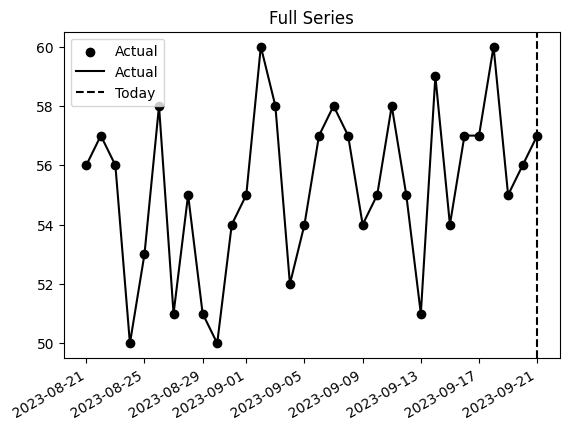

In [9]:
fig, ax = plt.subplots()

ax.scatter(rawSeries[TIME_COLUMN], rawSeries[TARGET_COLUMN], color = 'black', label = 'Actual')
ax.plot(rawSeries[TIME_COLUMN], rawSeries[TARGET_COLUMN], color = 'black', label = 'Actual')

fig.autofmt_xdate()
ax.set_title('Full Series')
ax.axvline(pd.Timestamp(datetime.today().strftime('%Y-%m-%d')), color = 'black', linestyle = '--', label = 'Today')
ax.legend(loc='best')

### Add Missing Days For Examples

In [10]:
query = f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` AS
    SELECT {TIME_COLUMN}, {TARGET_COLUMN},
        CASE
            WHEN RAND() < 0.80 THEN {TARGET_COLUMN}
            ELSE Null
        END AS {TARGET_COLUMN}_missing
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    ORDER BY {TIME_COLUMN}
"""
job = bq.query(query)
job.result()
(job.ended-job.started).total_seconds()

18.603

In [11]:
rawSeries = bq.query(query = f"SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`").to_dataframe()

In [12]:
rawSeries['demand_missing'] = rawSeries['demand_missing'].astype('float') # convert from int to float forces NA to NaN
rawSeries.head()

,time,demand,demand_missing
0,2023-08-21,56,NaN
1,2023-08-22,57,57.0
2,2023-08-23,56,56.0
3,2023-08-24,50,50.0
4,2023-08-25,53,53.0


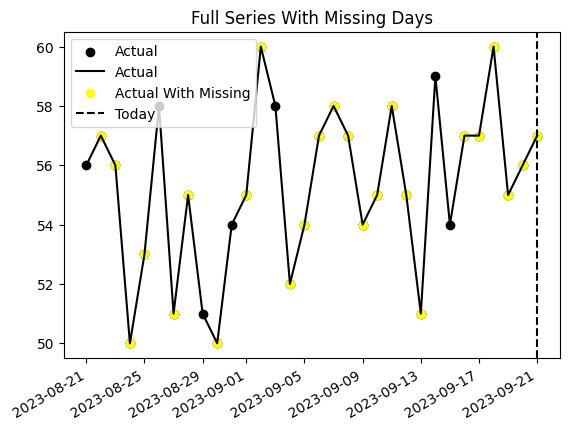

In [13]:
fig, ax = plt.subplots()

ax.scatter(rawSeries[TIME_COLUMN], rawSeries[TARGET_COLUMN], color = 'black', label = 'Actual')
ax.plot(rawSeries[TIME_COLUMN], rawSeries[TARGET_COLUMN], color = 'black', label = 'Actual')
ax.scatter(rawSeries[TIME_COLUMN], rawSeries[f'{TARGET_COLUMN}_missing'], color = 'yellow', label = 'Actual With Missing')

fig.autofmt_xdate()
ax.set_title('Full Series With Missing Days')
ax.axvline(pd.Timestamp(datetime.today().strftime('%Y-%m-%d')), color = 'black', linestyle = '--', label = 'Today')
ax.legend(loc='best')

## Forecast: Full Series

In [14]:
query = f"""
    CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus_full`
    OPTIONS
      (model_type = 'ARIMA_PLUS',
       time_series_timestamp_col = '{TIME_COLUMN}',
       time_series_data_col = '{TARGET_COLUMN}',
       data_frequency = '{FORECAST_GRANULARITY}',
       horizon = 10
      ) AS
    SELECT {TIME_COLUMN}, {TARGET_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
"""
job = bq.query(query)
job.result()
(job.ended-job.started).total_seconds()

13.043

In [15]:
query = f"""
    SELECT *, 
        EXTRACT(DATE FROM time_series_timestamp) AS {TIME_COLUMN}
    FROM ML.EXPLAIN_FORECAST(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus_full`,
        STRUCT(10 AS horizon, 0.95 AS confidence_level))
    ORDER BY {TIME_COLUMN}
"""
explain = bq.query(query).to_dataframe()

In [16]:
explain.head()

,time_series_timestamp,time_series_type,time_series_data,time_series_adjusted_data,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,trend,seasonal_period_yearly,seasonal_period_quarterly,seasonal_period_monthly,seasonal_period_weekly,seasonal_period_daily,holiday_effect,spikes_and_dips,step_changes,time
0,2023-08-21 00:00:00+00:00,history,56.0,56.0000,2.743601,NaN,NaN,NaN,55.3125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-08-21
1,2023-08-22 00:00:00+00:00,history,57.0,55.3125,2.743601,NaN,NaN,NaN,55.3125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-08-22
2,2023-08-23 00:00:00+00:00,history,56.0,55.3125,2.743601,NaN,NaN,NaN,55.3125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-08-23
3,2023-08-24 00:00:00+00:00,history,50.0,55.3125,2.743601,NaN,NaN,NaN,55.3125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-08-24
4,2023-08-25 00:00:00+00:00,history,53.0,55.3125,2.743601,NaN,NaN,NaN,55.3125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-08-25


In [17]:
explain.tail()

,time_series_timestamp,time_series_type,time_series_data,time_series_adjusted_data,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,trend,seasonal_period_yearly,seasonal_period_quarterly,seasonal_period_monthly,seasonal_period_weekly,seasonal_period_daily,holiday_effect,spikes_and_dips,step_changes,time
37,2023-09-27 00:00:00+00:00,forecast,55.3125,55.3125,2.743601,0.95,49.944761,60.680239,55.3125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-09-27
38,2023-09-28 00:00:00+00:00,forecast,55.3125,55.3125,2.743601,0.95,49.944761,60.680239,55.3125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-09-28
39,2023-09-29 00:00:00+00:00,forecast,55.3125,55.3125,2.743601,0.95,49.944761,60.680239,55.3125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-09-29
40,2023-09-30 00:00:00+00:00,forecast,55.3125,55.3125,2.743601,0.95,49.944761,60.680239,55.3125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-09-30
41,2023-10-01 00:00:00+00:00,forecast,55.3125,55.3125,2.743601,0.95,49.944761,60.680239,55.3125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-10-01


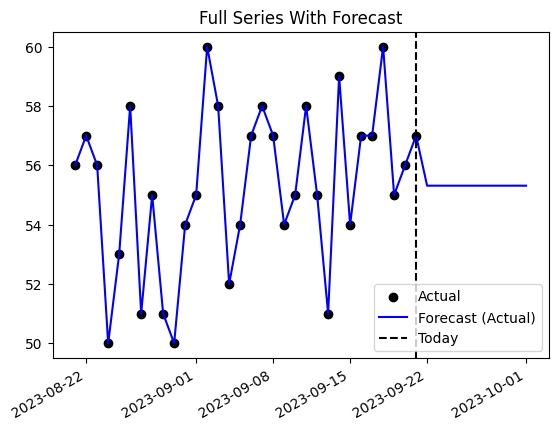

In [18]:
fig, ax = plt.subplots()

ax.scatter(rawSeries[TIME_COLUMN], rawSeries[TARGET_COLUMN], color = 'black', label = 'Actual')
ax.plot(explain['time_series_timestamp'], explain['time_series_data'], color = 'blue', label = 'Forecast (Actual)')

fig.autofmt_xdate()
ax.set_title('Full Series With Forecast')
ax.axvline(pd.Timestamp(datetime.today().strftime('%Y-%m-%d')), color = 'black', linestyle = '--', label = 'Today')
ax.legend(loc='best')

## Forecast: Full Series With Missing Days

In [19]:
query = f"""
    CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus_full_missing`
    OPTIONS
      (model_type = 'ARIMA_PLUS',
       time_series_timestamp_col = '{TIME_COLUMN}',
       time_series_data_col = '{TARGET_COLUMN}_missing',
       data_frequency = '{FORECAST_GRANULARITY}',
       horizon = 10
      ) AS
    SELECT {TIME_COLUMN}, {TARGET_COLUMN}_missing
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
"""
job = bq.query(query)
job.result()
(job.ended-job.started).total_seconds()

11.048

In [20]:
query = f"""
    SELECT *, 
        EXTRACT(DATE FROM time_series_timestamp) AS {TIME_COLUMN}
    FROM ML.EXPLAIN_FORECAST(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus_full_missing`,
        STRUCT(10 AS horizon, 0.95 AS confidence_level))
    ORDER BY {TIME_COLUMN}
"""
explain = bq.query(query).to_dataframe()

In [21]:
explain.head()

,time_series_timestamp,time_series_type,time_series_data,time_series_adjusted_data,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,trend,seasonal_period_yearly,seasonal_period_quarterly,seasonal_period_monthly,seasonal_period_weekly,seasonal_period_daily,holiday_effect,spikes_and_dips,step_changes,time
0,2023-08-22 00:00:00+00:00,history,57.0,57.000000,2.301106,NaN,NaN,NaN,54.884884,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-08-22
1,2023-08-23 00:00:00+00:00,history,56.0,55.802577,2.301106,NaN,NaN,NaN,55.802577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-08-23
2,2023-08-24 00:00:00+00:00,history,50.0,54.990405,2.301106,NaN,NaN,NaN,54.990405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-08-24
3,2023-08-25 00:00:00+00:00,history,53.0,52.065971,2.301106,NaN,NaN,NaN,52.065971,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-08-25
4,2023-08-26 00:00:00+00:00,history,52.0,55.421697,2.301106,NaN,NaN,NaN,55.421697,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-08-26


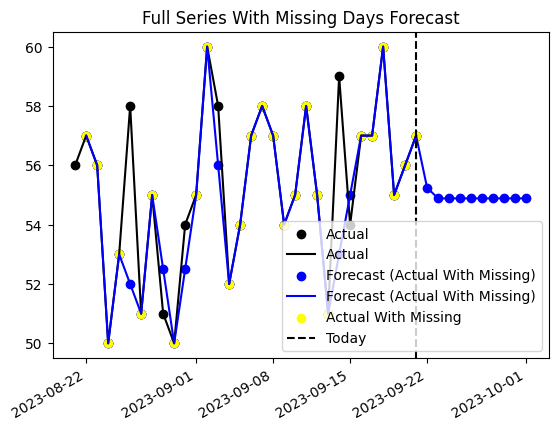

In [22]:
fig, ax = plt.subplots()

ax.scatter(rawSeries[TIME_COLUMN], rawSeries[TARGET_COLUMN], color = 'black', label = 'Actual')
ax.plot(rawSeries[TIME_COLUMN], rawSeries[TARGET_COLUMN], color = 'black', label = 'Actual')
ax.scatter(explain['time_series_timestamp'], explain['time_series_data'], color = 'blue', label = 'Forecast (Actual With Missing)')
ax.plot(explain['time_series_timestamp'], explain['time_series_data'], color = 'blue', label = 'Forecast (Actual With Missing)')
ax.scatter(rawSeries[TIME_COLUMN], rawSeries[f'{TARGET_COLUMN}_missing'], color = 'yellow', label = 'Actual With Missing')

fig.autofmt_xdate()
ax.set_title('Full Series With Missing Days Forecast')
ax.axvline(pd.Timestamp(datetime.today().strftime('%Y-%m-%d')), color = 'black', linestyle = '--', label = 'Today')
ax.legend(loc='best')

## Forecast: Full Series With Missing Days (Absent Rows)

In [23]:
rawSeries = bq.query(query = f"SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE {TARGET_COLUMN}_missing IS NOT NULL").to_dataframe()

In [25]:
query = f"""
    CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus_full_missingAbsent`
    OPTIONS
      (model_type = 'ARIMA_PLUS',
       time_series_timestamp_col = '{TIME_COLUMN}',
       time_series_data_col = '{TARGET_COLUMN}_missing',
       data_frequency = '{FORECAST_GRANULARITY}',
       horizon = 10
      ) AS
    SELECT {TIME_COLUMN}, {TARGET_COLUMN}_missing
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE {TARGET_COLUMN}_missing IS NOT NULL
"""
job = bq.query(query)
job.result()
(job.ended-job.started).total_seconds()

12.863

In [26]:
query = f"""
    SELECT *, 
        EXTRACT(DATE FROM time_series_timestamp) AS {TIME_COLUMN}
    FROM ML.EXPLAIN_FORECAST(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus_full_missing`,
        STRUCT(10 AS horizon, 0.95 AS confidence_level))
    ORDER BY {TIME_COLUMN}
"""
explain = bq.query(query).to_dataframe()

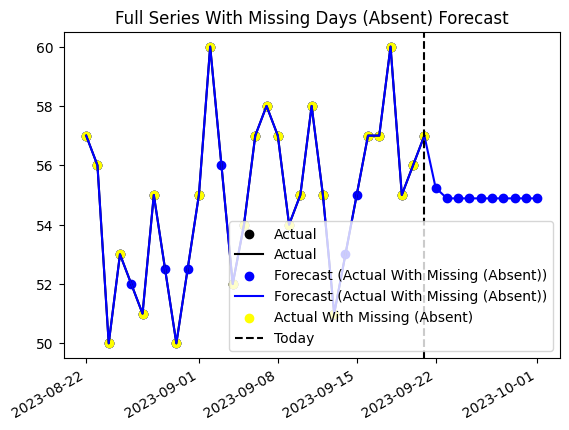

In [27]:
fig, ax = plt.subplots()

ax.scatter(rawSeries[TIME_COLUMN], rawSeries[TARGET_COLUMN], color = 'black', label = 'Actual')
ax.plot(rawSeries[TIME_COLUMN], rawSeries[TARGET_COLUMN], color = 'black', label = 'Actual')
ax.scatter(explain['time_series_timestamp'], explain['time_series_data'], color = 'blue', label = 'Forecast (Actual With Missing (Absent))')
ax.plot(explain['time_series_timestamp'], explain['time_series_data'], color = 'blue', label = 'Forecast (Actual With Missing (Absent))')
ax.scatter(rawSeries[TIME_COLUMN], rawSeries[f'{TARGET_COLUMN}_missing'], color = 'yellow', label = 'Actual With Missing (Absent)')


fig.autofmt_xdate()
ax.set_title('Full Series With Missing Days (Absent) Forecast')
ax.axvline(pd.Timestamp(datetime.today().strftime('%Y-%m-%d')), color = 'black', linestyle = '--', label = 'Today')
ax.legend(loc='best')

## Forecast: Full Series - Weekly

ARIMA+ will not aggregate to a higher granularity.  This makes sense as it would require take a sum, min, max, avg, .... and the choice of aggregation would depend on the data.

In [28]:
query = f"""
    CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus_full_weekly`
    OPTIONS
      (model_type = 'ARIMA_PLUS',
       time_series_timestamp_col = '{TIME_COLUMN}',
       time_series_data_col = '{TARGET_COLUMN}',
       data_frequency = 'WEEKLY',
       horizon = 2
      ) AS
    SELECT {TIME_COLUMN}, {TARGET_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
"""
job = bq.query(query)
job.result()
(job.ended-job.started).total_seconds()

BadRequest: 400 Invalid time series: All input time intervals must be no less than the internval unit specified by data_frequency (WEEKLY)

Location: US
Job ID: ee88a710-1202-48fa-846e-2da0839adc19


## Forecast: Full Series - Hourly

ARIMA+ will allow specifying lower levels of granularity and it iterpolates the values as though they are missing (absent) from the data.

In [29]:
rawSeries = bq.query(query = f"SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`").to_dataframe()

In [30]:
rawSeries.head()

,time,demand,demand_missing
0,2023-08-21,56,<NA>
1,2023-08-22,57,57
2,2023-08-23,56,56
3,2023-08-24,50,50
4,2023-08-25,53,53


In [31]:
query = f"""
    CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus_full_hourly`
    OPTIONS
      (model_type = 'ARIMA_PLUS',
       time_series_timestamp_col = '{TIME_COLUMN}',
       time_series_data_col = '{TARGET_COLUMN}',
       data_frequency = 'HOURLY',
       horizon = 240
      ) AS
    SELECT CAST({TIME_COLUMN} AS TIMESTAMP) AS {TIME_COLUMN}, {TARGET_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
"""
job = bq.query(query)
job.result()
(job.ended-job.started).total_seconds()

11.86

In [32]:
query = f"""
    SELECT *, 
        time_series_timestamp AS {TIME_COLUMN}
    FROM ML.EXPLAIN_FORECAST(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus_full_hourly`,
        STRUCT(240 AS horizon, 0.95 AS confidence_level))
    ORDER BY {TIME_COLUMN}
"""
explain = bq.query(query).to_dataframe()

In [33]:
explain.head()

,time_series_timestamp,time_series_type,time_series_data,time_series_adjusted_data,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,trend,seasonal_period_yearly,seasonal_period_quarterly,seasonal_period_monthly,seasonal_period_weekly,seasonal_period_daily,holiday_effect,spikes_and_dips,step_changes,time
0,2023-08-21 00:00:00+00:00,history,56.000000,56.000000,0.052058,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,2023-08-21 00:00:00+00:00
1,2023-08-21 01:00:00+00:00,history,56.041667,56.000458,0.052058,NaN,NaN,NaN,56.000458,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,2023-08-21 01:00:00+00:00
2,2023-08-21 02:00:00+00:00,history,56.083333,56.080865,0.052058,NaN,NaN,NaN,56.080865,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,2023-08-21 02:00:00+00:00
3,2023-08-21 03:00:00+00:00,history,56.125000,56.122532,0.052058,NaN,NaN,NaN,56.122532,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,2023-08-21 03:00:00+00:00
4,2023-08-21 04:00:00+00:00,history,56.166667,56.164199,0.052058,NaN,NaN,NaN,56.164199,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,2023-08-21 04:00:00+00:00


In [34]:
explain.tail()

,time_series_timestamp,time_series_type,time_series_data,time_series_adjusted_data,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,trend,seasonal_period_yearly,seasonal_period_quarterly,seasonal_period_monthly,seasonal_period_weekly,seasonal_period_daily,holiday_effect,spikes_and_dips,step_changes,time
980,2023-09-30 20:00:00+00:00,forecast,57.661737,57.661737,12.794082,0.95,32.630652,82.692823,57.661737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-09-30 20:00:00+00:00
981,2023-09-30 21:00:00+00:00,forecast,57.661737,57.661737,12.824230,0.95,32.571668,82.751807,57.661737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-09-30 21:00:00+00:00
982,2023-09-30 22:00:00+00:00,forecast,57.661737,57.661737,12.854308,0.95,32.512822,82.810652,57.661737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-09-30 22:00:00+00:00
983,2023-09-30 23:00:00+00:00,forecast,57.661737,57.661737,12.884316,0.95,32.454114,82.869361,57.661737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-09-30 23:00:00+00:00
984,2023-10-01 00:00:00+00:00,forecast,57.661737,57.661737,12.914253,0.95,32.395542,82.927933,57.661737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-10-01 00:00:00+00:00


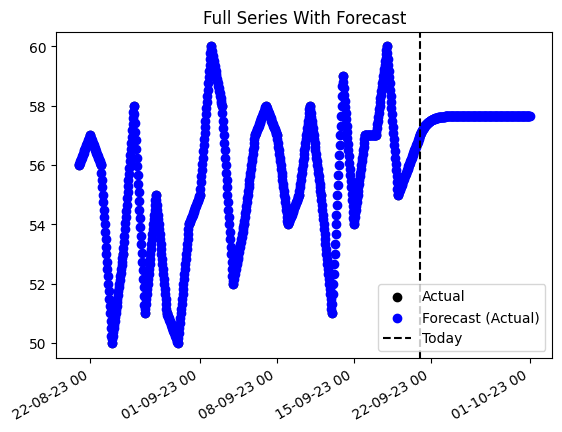

In [35]:
fig, ax = plt.subplots()

ax.scatter(rawSeries[TIME_COLUMN], rawSeries[TARGET_COLUMN], color = 'black', label = 'Actual')
ax.scatter(explain['time_series_timestamp'], explain['time_series_data'], color = 'blue', label = 'Forecast (Actual)')

fig.autofmt_xdate()
import matplotlib.dates as mdates
xfmt = mdates.DateFormatter('%d-%m-%y %H')
ax.xaxis.set_major_formatter(xfmt)
ax.set_title('Full Series With Forecast')
ax.axvline(pd.Timestamp(datetime.today().strftime('%Y-%m-%d')), color = 'black', linestyle = '--', label = 'Today')
ax.legend(loc='best')